In [57]:

import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
%matplotlib inline
import numpy as np
#from wordcloud import WordCloud
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from IPython.display import display, HTML
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import itertools
import gensim
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

**Questions we'd like to answer**
* What are the most common ingredients?
* Can we cluster dishes?
* Recommendation system for similar recipes?


In [2]:


ingredients_df = pd.read_csv("C:/Users/karth/NLP Assignments/Recipes/cleanings.txt", 
                             sep=" ", 
                             header=None, 
                             names=["ingredients"],
                             index_col=False)

recipes_df = pd.read_csv("C:/Users/karth/NLP Assignments/Recipes/classes_Recipes5k.txt", 
                         header=None, 
                         names=["recipe_name"],
                         index_col=False)


ingredients_df.reset_index(drop=True, inplace=True)
recipes_df.reset_index(drop=True, inplace=True)


In [3]:
ingredients_df.head()


,ingredients
0,"egg,flour,salt,onion,milk,coconut,baking,bread"
1,"panko,egg,garlic,flour,salt,onion,cayenne,papr..."
2,"egg,flour,onion,oil,baking,bread"
3,"cake,oil,onion"
4,"egg,flour,onion,celery,nut,baking,ale"


In [4]:
recipes_df.head()

,recipe_name
0,Einkorn Onion Rings
1,Crispy Onion Rings
2,Onion Rings
3,Onion Rings_2
4,Onion Rings_3


In [5]:
food_df = pd.concat([recipes_df, ingredients_df], axis=1)
food_df.head()

,recipe_name,ingredients
0,Einkorn Onion Rings,"egg,flour,salt,onion,milk,coconut,baking,bread"
1,Crispy Onion Rings,"panko,egg,garlic,flour,salt,onion,cayenne,papr..."
2,Onion Rings,"egg,flour,onion,oil,baking,bread"
3,Onion Rings_2,"cake,oil,onion"
4,Onion Rings_3,"egg,flour,onion,celery,nut,baking,ale"


In [6]:
#df of cleaned dish names
unirecipes_df = pd.read_csv("C:/Users/karth/NLP Assignments/Recipes/clean_recipe_names.txt", 
                             header=None, 
                             names=["dish"],
                             index_col=False)



In [7]:
#unique dishes in the dataset
dishes_df = pd.DataFrame(unirecipes_df.drop_duplicates(["dish"]))


In [8]:
dishes_df.head()

,dish
0,apple_pie
35,croque_madame
70,paella
105,gyoza
138,crab_cakes


In [9]:
#no. of unique dishes in the dataset
print(dishes_df.shape)

(101, 1)


In [10]:
#most commonly occuring dishes in the dataset
counts_df = unirecipes_df.groupby(['dish']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)


In [11]:
# all dishes with 50 different dishes
counts_df.loc[counts_df['counts']==50].head()


,dish,counts
100,waffles,50
26,clam_chowder,50
28,crab_cakes,50
29,creme_brulee,50
60,lasagna,50


**Mapping unique recipes and dishes**

In [12]:
def map_recipes_and_dish(recipe):
    for dish in dishes_df.itertuples():
        if dish[1].replace("_"," ") in recipe.replace("_", " ").replace("-"," ").lower():
            return dish[1]

In [13]:
food_df["dish"] = food_df.recipe_name.apply(map_recipes_and_dish)


In [14]:
food_df.shape


(4826, 3)

In [15]:
food_df.head()

,recipe_name,ingredients,dish
0,Einkorn Onion Rings,"egg,flour,salt,onion,milk,coconut,baking,bread",onion_rings
1,Crispy Onion Rings,"panko,egg,garlic,flour,salt,onion,cayenne,papr...",onion_rings
2,Onion Rings,"egg,flour,onion,oil,baking,bread",onion_rings
3,Onion Rings_2,"cake,oil,onion",onion_rings
4,Onion Rings_3,"egg,flour,onion,celery,nut,baking,ale",onion_rings


In [16]:
inds = pd.isnull(food_df['dish'])  
food_df[inds]

,recipe_name,ingredients,dish
49,Spiced Apple Lattice Pie,brown,None
81,Apple Mummy Pie!,brown,None
85,Vermont Apple Slab Pie,"sugar,apple,pie,maple",None
89,Apple Slab Pie,brown,None
191,75 Japanese gyo\u0304za (\u9903\u5b50),"pork,shiitake,black",None
...,...,...,...
4767,Caprese Stack Salad,"avocado,salt,tomato,basil,pepper,oil,balsamic",None
4774,Easy Caprese Tortellini Salad,"tomato,mozzarella,cheese,basil",None
4786,Creamy 3-ingredient,condensed,None
4809,Chocolate Cookies and Cream Ice Cream,brown,None


In [17]:
#remove recipes with no dish name
food_df.dropna(subset=["dish"], inplace=True)
food_df = food_df.reset_index(drop=True)
food_df.shape

(4327, 3)

In [18]:
food_df

,recipe_name,ingredients,dish
0,Einkorn Onion Rings,"egg,flour,salt,onion,milk,coconut,baking,bread",onion_rings
1,Crispy Onion Rings,"panko,egg,garlic,flour,salt,onion,cayenne,papr...",onion_rings
2,Onion Rings,"egg,flour,onion,oil,baking,bread",onion_rings
3,Onion Rings_2,"cake,oil,onion",onion_rings
4,Onion Rings_3,"egg,flour,onion,celery,nut,baking,ale",onion_rings
...,...,...,...
4322,Chocolate Ice Cream_21,"sugar,egg,chocolate,water,milk,cocoa,whipping",chocolate_ice_cream
4323,Dark Chocolate Ice Cream,"sugar,egg,salt,vanilla,chocolate,dutch",chocolate_ice_cream
4324,The Darkest Chocolate Ice Cream,"sugar,corn",chocolate_ice_cream
4325,Homemade Chocolate Ice Cream_4,brown,chocolate_ice_cream


# Dishes with most recipes 


In [19]:
food_df['dish'].value_counts()
#steak has the most recipes.

steak             86
hummus            58
lasagna           54
pizza             54
guacamole         53
                  ..
beef_carpaccio    11
escargots          8
takoyaki           5
cheese_plate       3
beef_tartare       3
Name: dish, Length: 100, dtype: int64

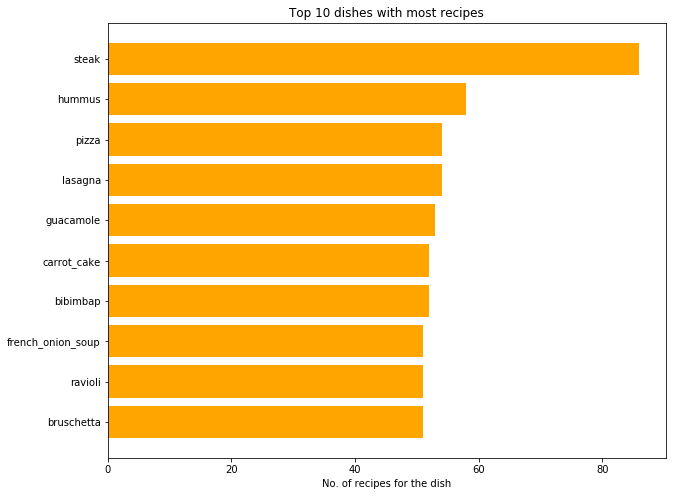

In [20]:
recipes_per_dish = food_df.groupby(["dish"])["recipe_name"].agg(['count'])\
            .sort_values(by = "count", ascending=False)\
            .rename(columns={"count" : "recipes_count"}).iloc[: 10] 

recipes_per_dish = recipes_per_dish.sort_values(by = 'recipes_count')

plt.figure(figsize=(10, 8))
plt.barh(recipes_per_dish.index, recipes_per_dish.recipes_count, color="orange")
plt.title("Top 10 dishes with most recipes")
plt.xlabel("No. of recipes for the dish")
plt.show()

#steak has the most recipes

# Dishes with the least recipes

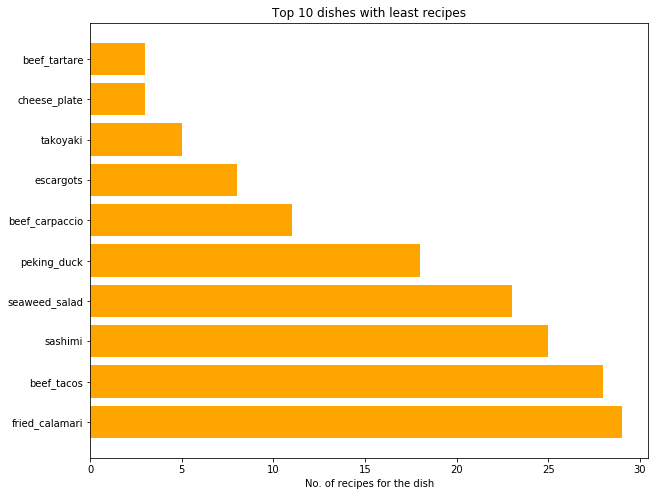

In [21]:
recipes_per_dish = food_df.groupby(["dish"])["recipe_name"].agg(['count'])\
            .sort_values(by = "count", ascending=True)\
            .rename(columns={"count" : "recipes_count"}).iloc[: 10] 

recipes_per_dish = recipes_per_dish.sort_values(by = 'recipes_count', ascending = False)

plt.figure(figsize=(10, 8))
plt.barh(recipes_per_dish.index, recipes_per_dish.recipes_count, color="orange")
plt.title("Top 10 dishes with least recipes")
plt.xlabel("No. of recipes for the dish")
plt.show()

#beef tartare has the least recipes

# Most commonly occurring ingrdients within recipes
**using Market Basket Analysis to determine commonly occurring ingredients**

In [22]:
#convert ingrdients to transactions
transactions = food_df['ingredients'].apply(lambda t: t.split(','))


In [23]:
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from itertools import combinations
from operator import itemgetter
from mlxtend.preprocessing import TransactionEncoder



In [24]:
food_df2 = food_df.drop(columns = ['recipe_name','dish'])
lol = food_df2.values.tolist()


In [25]:
for i in range(len(lol)):
    lol[i] = lol[i][0].split(',')


In [26]:
#prepare data fro apriori

te = TransactionEncoder()
te_ary = te.fit(lol).transform(lol)
ings_df = pd.DataFrame(te_ary, columns=te.columns_)


In [27]:
#itemsets present in atleast 10% of the recipes
apriori(ings_df, min_support=0.1, use_colnames = True)

,support,itemsets
0,0.152300,(black)
1,0.186041,(butter)
2,0.134966,(cheese)
3,0.259071,(egg)
4,0.150913,(flour)
5,0.141437,(garlic)
6,0.188583,(oil)
7,0.147446,(onion)
8,0.163855,(pepper)
9,0.346429,(salt)


In [28]:
itemsets = apriori(ings_df, min_support=0.005, use_colnames=True)
itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))


# Top 10 most individually occurring ingredients in recipes

In [29]:
itemsets.loc[itemsets['length'] == 1].sort_values('support', ascending = False).iloc[:10]

,support,itemsets,length
121,0.346429,(salt),1
57,0.259071,(egg),1
137,0.228565,(sugar),1
94,0.188583,(oil),1
20,0.186041,(butter),1
105,0.163855,(pepper),1
15,0.152300,(black),1
63,0.150913,(flour),1
97,0.147446,(onion),1
64,0.141437,(garlic),1


# 10 least used ingredients

In [30]:
itemsets.loc[itemsets['length'] == 1].sort_values('support', ascending = True).iloc[:10]

,support,itemsets,length
154,0.005084,(yeast),1
1,0.005084,(anise),1
21,0.005084,(cabbage),1
115,0.005084,(rosemary),1
112,0.005084,(ravioli),1
109,0.005084,(plain),1
69,0.005084,(green),1
150,0.005315,(whipped),1
68,0.005315,(greek),1
98,0.005315,(orange),1


# Most commonly occurring pairs of ingredients

In [31]:
itemsets.loc[itemsets['length'] == 2].sort_values('support', ascending = False).iloc[:10]

,support,itemsets,length
568,0.138433,"(egg, salt)",2
574,0.137278,"(egg, sugar)",2
745,0.124567,"(oil, salt)",2
803,0.122718,"(pepper, salt)",2
312,0.113705,"(butter, salt)",2
842,0.113474,"(sugar, salt)",2
607,0.112318,"(flour, salt)",2
297,0.098220,"(egg, butter)",2
315,0.097296,"(sugar, butter)",2
867,0.095216,"(sugar, vanilla)",2


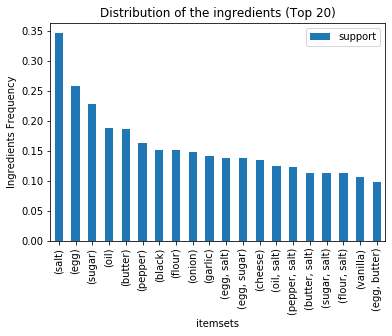

In [32]:
ax = itemsets.sort_values(by="support", ascending=False).head(20)\
        .plot(x="itemsets", y="support", kind="bar")
ax.set_title("Distribution of the ingredients (Top 20)")
b = ax.set_ylabel("Ingredients Frequency")

We see that salt, egg, sugar and oil are very prominent among the ingrdients used in recipes. 

In [33]:
freq_itemsets = apriori(ings_df, min_support=0.05, use_colnames=True)
arules = association_rules(freq_itemsets, metric="lift", min_threshold=1)
arules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(egg),(butter),0.259071,0.186041,0.098220,0.379126,2.037860,0.050023,1.310988
1,(butter),(egg),0.186041,0.259071,0.098220,0.527950,2.037860,0.050023,1.569600
2,(butter),(flour),0.186041,0.150913,0.080194,0.431056,2.856323,0.052118,1.492391
3,(flour),(butter),0.150913,0.186041,0.080194,0.531394,2.856323,0.052118,1.736978
4,(butter),(salt),0.186041,0.346429,0.113705,0.611180,1.764227,0.049255,1.680908
...,...,...,...,...,...,...,...,...,...
203,"(flour, salt)","(egg, sugar)",0.112318,0.137278,0.051075,0.454733,3.312504,0.035656,1.582200
204,(egg),"(sugar, flour, salt)",0.259071,0.064248,0.051075,0.197145,3.068519,0.034430,1.165531
205,(sugar),"(egg, flour, salt)",0.228565,0.068408,0.051075,0.223458,3.266564,0.035439,1.199668
206,(flour),"(egg, sugar, salt)",0.150913,0.077652,0.051075,0.338438,4.358396,0.039356,1.394197


**Rules with the highest lift:**

In [34]:
arules.sort_values(by = 'lift', ascending =  False).iloc[:10]

#all arules with a high lift value are very likely to occur together. Lift value of 6.6 for the first arule tells us
#that the likelihood of egg,sugar,butter and vanilla occurring together in recipes is 6.6 times more than the likelihood
#of occurrence of vanilla.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
193,(vanilla),"(egg, sugar, butter)",0.106771,0.072336,0.051306,0.480519,6.642836,0.043582,1.785752
180,"(egg, sugar, butter)",(vanilla),0.072336,0.106771,0.051306,0.709265,6.642836,0.043582,3.072314
187,"(sugar, butter)","(egg, vanilla)",0.097296,0.079963,0.051306,0.527316,6.594497,0.043526,1.946410
186,"(egg, vanilla)","(sugar, butter)",0.079963,0.097296,0.051306,0.641618,6.594497,0.043526,2.518835
189,"(butter, vanilla)","(egg, sugar)",0.062861,0.137278,0.051306,0.816176,5.945447,0.042676,4.693210
184,"(egg, sugar)","(butter, vanilla)",0.137278,0.062861,0.051306,0.373737,5.945447,0.042676,1.496399
106,"(sugar, butter)",(vanilla),0.097296,0.106771,0.059626,0.612827,5.739612,0.049237,2.307050
111,(vanilla),"(sugar, butter)",0.106771,0.097296,0.059626,0.558442,5.739612,0.049237,2.044359
185,"(egg, butter)","(sugar, vanilla)",0.098220,0.095216,0.051306,0.522353,5.485974,0.041954,1.894252
188,"(sugar, vanilla)","(egg, butter)",0.095216,0.098220,0.051306,0.538835,5.485974,0.041954,1.955438


**Rules with highest confidence:**

In [35]:
arules.sort_values(by = 'confidence', ascending =  False).iloc[:10]

#high confidence value for a rule tells us that the items in the lhs and rhs of the rule are very likely to occur together.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
182,"(egg, butter, vanilla)",(sugar),0.053848,0.228565,0.051306,0.952790,4.168575,0.038998,16.340400
108,"(butter, vanilla)",(sugar),0.062861,0.228565,0.059626,0.948529,4.149936,0.045258,14.987883
162,"(vanilla, salt)",(sugar),0.057777,0.228565,0.054772,0.948000,4.147620,0.041567,14.835292
137,"(egg, vanilla)",(sugar),0.079963,0.228565,0.074416,0.930636,4.071649,0.056140,11.121524
63,(vanilla),(sugar),0.106771,0.228565,0.095216,0.891775,3.901628,0.070812,7.128061
132,"(vanilla, salt)",(egg),0.057777,0.259071,0.050612,0.876000,3.381313,0.035644,5.975234
183,"(sugar, butter, vanilla)",(egg),0.059626,0.259071,0.051306,0.860465,3.321349,0.035858,5.309992
84,"(butter, vanilla)",(egg),0.062861,0.259071,0.053848,0.856618,3.306498,0.037562,5.167505
194,"(egg, sugar, flour)",(salt),0.060550,0.346429,0.051075,0.843511,2.434873,0.030098,4.176476
148,"(sugar, flour)",(salt),0.076728,0.346429,0.064248,0.837349,2.417085,0.037667,4.018249


**Useful rules: i.e. rules with high lift and confidence values**

In [36]:
arules[( arules['lift'] >= 3) & (arules['confidence'] >= 0.7)]

#We see that sugar and egg occur alot in the consequents. Sugar and egg are more likely to occur with other ingredients in
#recipes rather than just on their own.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
63,(vanilla),(sugar),0.106771,0.228565,0.095216,0.891775,3.901628,0.070812,7.128061
77,"(egg, butter)",(sugar),0.098220,0.228565,0.072336,0.736471,3.222152,0.049887,2.927321
84,"(butter, vanilla)",(egg),0.062861,0.259071,0.053848,0.856618,3.306498,0.037562,5.167505
95,"(sugar, flour)",(butter),0.076728,0.186041,0.054310,0.707831,3.804703,0.040036,2.785921
108,"(butter, vanilla)",(sugar),0.062861,0.228565,0.059626,0.948529,4.149936,0.045258,14.987883
120,"(sugar, flour)",(egg),0.076728,0.259071,0.060550,0.789157,3.046102,0.040672,3.514121
132,"(vanilla, salt)",(egg),0.057777,0.259071,0.050612,0.876000,3.381313,0.035644,5.975234
137,"(egg, vanilla)",(sugar),0.079963,0.228565,0.074416,0.930636,4.071649,0.056140,11.121524
138,"(sugar, vanilla)",(egg),0.095216,0.259071,0.074416,0.781553,3.016754,0.049749,3.391809
162,"(vanilla, salt)",(sugar),0.057777,0.228565,0.054772,0.948000,4.147620,0.041567,14.835292


# PCA and t-SNE representation of dishes

In [37]:
# helper function to convert list of ingredients into a dict 
def convert_to_dict(lis):
    d = {}
    for a in lis:
        d[a] = 1
    return d

food_df["bagofwords"] = food_df.ingredients.str.split(',').apply(convert_to_dict)

print("Bag of words representation of ingredients in recipes is:")
print(food_df.bagofwords)


    

Bag of words representation of ingredients in recipes is:
0       {'egg': 1, 'flour': 1, 'salt': 1, 'onion': 1, ...
1       {'panko': 1, 'egg': 1, 'garlic': 1, 'flour': 1...
2       {'egg': 1, 'flour': 1, 'onion': 1, 'oil': 1, '...
3                       {'cake': 1, 'oil': 1, 'onion': 1}
4       {'egg': 1, 'flour': 1, 'onion': 1, 'celery': 1...
                              ...                        
4322    {'sugar': 1, 'egg': 1, 'chocolate': 1, 'water'...
4323    {'sugar': 1, 'egg': 1, 'salt': 1, 'vanilla': 1...
4324                              {'sugar': 1, 'corn': 1}
4325                                         {'brown': 1}
4326    {'sugar': 1, 'salt': 1, 'chocolate': 1, 'mint'...
Name: bagofwords, Length: 4327, dtype: object


In [38]:
#one hot encoding the recipes
vectorizer = DictVectorizer(sparse = False)
X = vectorizer.fit_transform(food_df.bagofwords.tolist())
y = food_df.dish.astype("category").cat.codes

print("Shape of X and y after one hot encoding of the ingredients")
print(X.shape)
print(X)
print(y.shape)
print(y)


Shape of X and y after one hot encoding of the ingredients
(4327, 662)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4327,)
0       68
1       68
2       68
3       68
4       68
        ..
4322    23
4323    23
4324    23
4325    23
4326    23
Length: 4327, dtype: int8


In [39]:
ing_net = np.zeros((X.shape[1], X.shape[1]))
ing_net.shape

#array of dimensions 662 by 662 to calculate pairwise frequenccy.

(662, 662)

In [40]:
for ing_id in range(X.shape[1]):
    freq_vec = X[X[:,ing_id] == 1].sum(axis=0)
    freq_vec[ing_id] = 0
    ing_net[ing_id] = freq_vec
ing_net

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**PCA and t-SNE will help us understand how dishes are clustered based on the ingredients used to make them**

PCA on the dataset using cosine similarity

Note: to get better visualizations, we will use a subset of the dishes in the dataset

In [41]:
#no. of dishes in the dataset:
print("No of unique dishes in the dataset:")
print(len(food_df['dish'].unique()))

#there are 100 unique dishes within the dataset. We'll work with only a subset of these 100 dishes


list_dish_names = food_df.dish.astype("category").cat.categories


subset_dish = ['onion_rings', 'apple_pie', 'nachos', 'samosa', 'hummus','falafel','french_onion_soup',
              'chocolate_ice_cream','chocolate_cake', 'sushi', 'ravioli', 'baklava', 'tiramisu', 'caesar_salad',
              'stawberry_shortcake', 'guacamole', 'takoyaki', 'paella', 'waffles', 'dumplings']

print("No of dishes in the subset:")
print(len(subset_dish))

subset = food_df.dish.apply(lambda x : x in subset_dish)
X_subset, y_subset = X[subset], y[subset]

No of unique dishes in the dataset:
100
No of dishes in the subset:
20


**Principal Component Analysis (PCA)**

In [42]:
X_pca = KernelPCA(n_components=2, kernel="cosine", n_jobs=2).fit_transform(X_subset)


PCA plot: plotting PCA clusters obtained

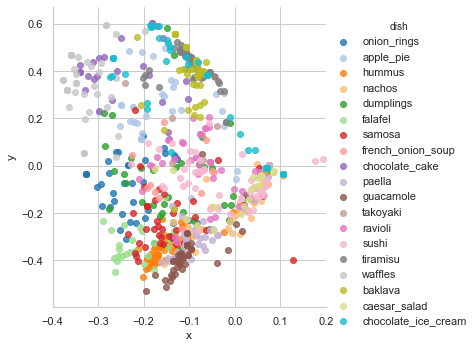

In [43]:
pca_df = pd.DataFrame(data = X_pca[:,:2], columns = ['x','y'])
pca_df['dish'] = list_dish_names[y_subset].tolist()

#plotting clusters obtained by PCA:
sn.set(style = "whitegrid", palette = "muted")
sn.lmplot("x", "y", data = pca_df, palette = "tab20", hue = "dish", fit_reg = False).set(xlim = (-0.4,0.2))


#We see that the clusters are not very well separated.

**t-SNE**

We compute t-SNE on the one hot encoded datset using cosine similarity

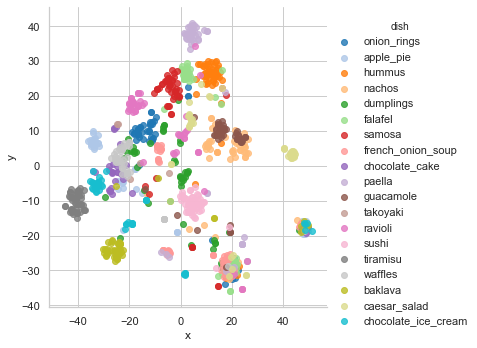

In [44]:
#compute cosine similarity square form for each vector 
X_cos = squareform(pdist(X_subset, metric = "cosine"))
X_tsne = TSNE(metric = "precomputed", perplexity = 25).fit_transform(X_cos)

#plotting t-SNE clusters 
tsne_df = pd.DataFrame(data = X_tsne[:,:2], columns = ["x","y"])
tsne_df["dish"] = list_dish_names[y_subset].tolist()

sn.set(style = "whitegrid", palette = "muted")
sn.lmplot("x", "y", data = tsne_df, palette = "tab20", hue = "dish", fit_reg = False)



#There is much better separation here. We can also see cluster regions akin to cuisines.
#Recipes belonging to the same dish are tightly clustered with good intra-dish separation.

**Now that we know there dishes in the datset which are similar to each other from PCA and t-SNE analysis, we can intuitively 
leverage this to come up with a recommendation system to recommend dishes which are similar**



We will use cosine similarity as a metric to see how similar 2 recipes are. A value close to 1 indicates high similarity and a value close to 0 indicate low similarity

In [67]:
def get_recipe_cosine_similariy(df, recipe_name, X, lim = 10):
    """ Takes a recipe name as input and returns its most similar recipes using cosine similarity """
    
    index = df.loc[df.recipe_name == recipe_name].index[0]
    # Fetch one hot encoding of the recipe and 
    # computes its cosine similarity with the rest of recipes
    items_M = X
    user_ing_vec = X[index]
    A = np.sqrt(np.square(user_ing_vec).sum())
    B = np.sqrt(np.square(X).sum(axis = 1))
    cosine_sim = items_M.dot(user_ing_vec.T) / (A * B)
    # Sort the most similar recipes and zip them with their ids
    best_id = np.argmax(cosine_sim)
    ids_sorted = np.argsort(-cosine_sim)
    return zip(df.loc[ids_sorted].recipe_name.tolist()[0:lim], cosine_sim[ids_sorted][0:lim])

In [68]:
recipe_name = "Samosa"
html = "<h4>Most similar recipes to {} according to cosine similarity</h4><ul>".format(recipe_name)

for i, sim_rec in enumerate(get_recipe_cosine_similariy(food_df, recipe_name, X)):
    if sim_rec[0] != recipe_name:
        html += "<li><b>{}</b> ({:.4}%)</li>".format(sim_rec[0], sim_rec[1]*100)
html += "</ul>"
display(HTML(html))

In [69]:
recipe_name = "Chocolate Cake"
html = "<h4>Most similar recipes to {} according to cosine similarity</h4><ul>".format(recipe_name)

for i, sim_rec in enumerate(get_recipe_cosine_similariy(food_df, recipe_name, X)):
    if sim_rec[0] != recipe_name:
        html += "<li><b>{}</b> ({:.4}%)</li>".format(sim_rec[0], sim_rec[1]*100)
html += "</ul>"
display(HTML(html))

In [73]:
recipe_name = "Sushi"
html = "<h4>Most similar recipes to {} according to cosine similarity</h4><ul>".format(recipe_name)

for i, sim_rec in enumerate(get_recipe_cosine_similariy(food_df, recipe_name, X)):
    if sim_rec[0] != recipe_name:
        html += "<li><b>{}</b> ({:.4}%)</li>".format(sim_rec[0], sim_rec[1]*100)
html += "</ul>"
display(HTML(html))